# 1.Sử dụng các checkpoint đã huấn luyện để đoán nhận dữ liệu

docs lib: https://keras.io/api/layers/recurrent_layers/lstm/

In [1]:
#@title Nhập tên các bộ dữ liệu đoán nhận
# là bộ dữ liệu hiện tại, được tạo trong lần đoán nhận này (tên file là lần đoán nhận này)
# sẽ trộn cả 2 bộ để đem ra đoán, nếu muốn đoán nhận từng bộ riêng lẻ thì comment lại bộ khác
# dùng model hiện tại để doán nhận bộ dữ liệu hiện tại => 2 bộ dưới là 2 bộ dữ liệu hiện tại
L_source = ",".join(map(lambda x: f"/cic/dataset/normalized_labeled/{x}/", [
    'nsm-2023w11-03-label',
    #'nsm-2023w09-01-label',
    #'nsm-2023w08-dos-01-label',
]))

In [2]:
#@title Nhập tên các checkpoint
# dòng đầu tiên, 2023W0702, là checkpoint hiện tại
# dòng thứ 2 trở đi, 2023W0701 ...., là các checkpoint quá khứ để đoán dữ liệu hiện tại là 2023W0702
# mỗi dòng, checkpoint là một model version được tải lên để đoán nhận các bộ dữ liệu L_source ở bên trên.
checkpoints = [
    '2023W1107',
    '2023W1106',
    '2023W0904',
    #'2023W0703',
    #'2023W0702',
    #'2023W0701',
    #'2023W0604',
]

# 2.PREPARATION

In [3]:
#@title Check version vs GPU
!git --version
!python --version
!ray --version

import tensorflow as tf
print('tf version: ', tf.__version__)
print('tf.keras version:', tf.keras.__version__)

import sys
sys.version

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  print('GPU device not found')
else:
  print('Found GPU at: {}'.format(device_name))

git version 2.20.1
Python 2.7.16
ray, version 1.13.0
tf version:  2.7.0
tf.keras version: 2.7.0
Found GPU at: /device:GPU:0


2023-03-17 16:53:00.779983: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-03-17 16:53:02.921880: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-17 16:53:02.923513: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-17 16:53:02.924581: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capabilit

In [4]:
#@title Import Libraries
!mkdir -p /cic/images/

import sys
sys.path.insert(0, "/usr/local/opnsense/scripts/ml")

import json
import ray
import pandas as pd
from pandas import DataFrame

from ray.data import Dataset
from ray.data.aggregate import Count

import numpy as np
from tensorflow import keras

import common
from anomaly_normalization import LABEL
from aitests.testutils import show_scattered_4d, show_weights, show_4d_imgs, IMG, read_csv_in_dir

run, client = common.init_experiment(name='notebook')


2023-03-17 16:53:05,831[INFO][139944504391488-MainThread] worker.py:init(957) Connecting to existing Ray cluster at address: 172.18.12.180:6379
2023-03-17 16:53:13,977[INFO][139944504391488-MainThread] migration.py:__init__(204) Context impl PostgresqlImpl.
2023-03-17 16:53:13,980[INFO][139944504391488-MainThread] migration.py:__init__(211) Will assume transactional DDL.


# 3.INPUT
Let's generate a sample input with time dimension as below:

In [5]:
#@title Generate an input sequence
n_timesteps_in = 100  #@param {type:"integer"}
n_features = 79   #@param {type:"integer"}

L_data: Dataset = read_csv_in_dir(L_source)
L_count: DataFrame = L_data.groupby(LABEL).aggregate(Count()).to_pandas()

features = ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pkt_len_max', 'pkt_len_mean', 'pkt_len_min', 'pkt_len_std', 'pkt_len_var', 'pkt_size_avg', 'protocol', 'psh_flag_cnt', 'rst_flag_cnt', 'src_port', 'subflow_bwd_byts', 'subflow_bwd_pkts', 'subflow_fwd_byts', 'subflow_fwd_pkts', 'syn_flag_cnt', 'tot_bwd_pkts', 'tot_fwd_pkts', 'totlen_bwd_pkts', 'totlen_fwd_pkts', 'urg_flag_cnt']
features = features[0: n_features]
Lpadding_features = sorted(list(set(features) - set(L_data.schema(fetch_if_missing=True).names)))

total_size = int(L_count.sum()['count()']) // n_timesteps_in
predict_size = total_size
print ('features=', features)
print ('Lpadding_features=', Lpadding_features)
print ('total_size = ', total_size)
print ('predict_size = ', predict_size)


L_predict = DataFrame.from_records(L_data.take(predict_size  * n_timesteps_in))
L_predict[Lpadding_features] = 0
LX_predict = L_predict[features].to_numpy().reshape(predict_size, n_timesteps_in, n_features)
Ly_predict = L_predict[[LABEL]].to_numpy().reshape((predict_size, n_timesteps_in))

2023-03-17 16:53:15,982	WARNING read_api.py:256 -- The number of blocks in this dataset (5) limits its parallelism to 5 concurrent tasks. This is much less than the number of available CPU slots in the cluster. Use `.repartition(n)` to increase the number of dataset blocks.
Shuffle Reduce: 100%|██████████| 1/1 [00:00<00:00,  6.49it/s]


features= ['ack_flag_cnt', 'active_max', 'active_mean', 'active_min', 'active_std', 'bwd_blk_rate_avg', 'bwd_byts_b_avg', 'bwd_header_len', 'bwd_iat_max', 'bwd_iat_mean', 'bwd_iat_min', 'bwd_iat_std', 'bwd_iat_tot', 'bwd_pkt_len_max', 'bwd_pkt_len_mean', 'bwd_pkt_len_min', 'bwd_pkt_len_std', 'bwd_pkts_b_avg', 'bwd_pkts_s', 'bwd_psh_flags', 'bwd_seg_size_avg', 'bwd_urg_flags', 'cwe_flag_count', 'down_up_ratio', 'dst_port', 'ece_flag_cnt', 'fin_flag_cnt', 'flow_byts_s', 'flow_duration', 'flow_iat_max', 'flow_iat_mean', 'flow_iat_min', 'flow_iat_std', 'flow_pkts_s', 'fwd_act_data_pkts', 'fwd_blk_rate_avg', 'fwd_byts_b_avg', 'fwd_header_len', 'fwd_iat_max', 'fwd_iat_mean', 'fwd_iat_min', 'fwd_iat_std', 'fwd_iat_tot', 'fwd_pkt_len_max', 'fwd_pkt_len_mean', 'fwd_pkt_len_min', 'fwd_pkt_len_std', 'fwd_pkts_b_avg', 'fwd_pkts_s', 'fwd_psh_flags', 'fwd_seg_size_avg', 'fwd_seg_size_min', 'fwd_urg_flags', 'idle_max', 'idle_mean', 'idle_min', 'idle_std', 'init_bwd_win_byts', 'init_fwd_win_byts', 'pk

In [6]:
L_count

label  count()
0    0.0    15069
1    1.0    10258

## Data preview

### L_train preview

In [7]:
L_predict[[LABEL, *features]]

label  ack_flag_cnt  active_max  active_mean  active_min  active_std  \
0        0.0      1.000000         0.0          0.0         0.0         0.0   
1        0.0      1.000000         0.0          0.0         0.0         0.0   
2        1.0      1.000000         0.0          0.0         0.0         0.0   
3        1.0      1.000000         0.0          0.0         0.0         0.0   
4        1.0      1.000000         0.0          0.0         0.0         0.0   
...      ...           ...         ...          ...         ...         ...   
25295    0.0      0.964028         0.0          0.0         0.0         0.0   
25296    0.0      0.964028         0.0          0.0         0.0         0.0   
25297    0.0      0.964028         0.0          0.0         0.0         0.0   
25298    0.0      0.964028         0.0          0.0         0.0         0.0   
25299    0.0      0.000000         0.0          0.0         0.0         0.0   

       bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  bwd_iat_max  \
0                   1.0             1.0             1.0          1.0   
1                   1.0             1.0             1.0          1.0   
2                   1.0             1.0             1.0          1.0   
3                   1.0             1.0             1.0          1.0   
4                   1.0             1.0             1.0          1.0   
...                 ...             ...             ...          ...   
25295               0.0             0.0             0.0          0.0   
25296               0.0             0.0             0.0          0.0   
25297               0.0             0.0             0.0          0.0   
25298               0.0             0.0             0.0          0.0   
25299               0.0             0.0             0.0          0.0   

       bwd_iat_mean  bwd_iat_min  bwd_iat_std  bwd_iat_tot  bwd_pkt_len_max  \
0               1.0          1.0          1.0          1.0              1.0   
1               1.0          1.0          1.0          1.0              1.0   
2               1.0          1.0          1.0          1.0              1.0   
3               1.0          1.0          1.0          1.0              1.0   
4               1.0          1.0          1.0          1.0              1.0   
...             ...          ...          ...          ...              ...   
25295           0.0          0.0          0.0          0.0              0.0   
25296           0.0          0.0          0.0          0.0              0.0   
25297           0.0          0.0          0.0          0.0              0.0   
25298           0.0          0.0          0.0          0.0              0.0   
25299           0.0          0.0          0.0          0.0              0.0   

       bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  bwd_pkts_b_avg  \
0                   1.0              0.0              1.0             1.0   
1                   1.0              0.0              1.0             1.0   
2                   1.0              0.0              1.0             1.0   
3                   1.0              0.0              1.0             1.0   
4                   1.0              0.0              1.0             1.0   
...                 ...              ...              ...             ...   
25295               0.0              0.0              0.0             0.0   
25296               0.0              0.0              0.0             0.0   
25297               0.0              0.0              0.0             0.0   
25298               0.0              0.0              0.0             0.0   
25299               0.0              0.0              0.0             0.0   

       bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  bwd_urg_flags  \
0             1.0            0.0               1.0            0.0   
1             1.0            0.0               1.0            0.0   
2             1.0            0.0               1.0            0.0   
3             1.0            0.0           

In [8]:
L_predict[[LABEL, *features]].describe()

label  ack_flag_cnt    active_max   active_mean    active_min  \
count  25300.000000  25300.000000  25300.000000  25300.000000  25300.000000   
mean       0.405455      0.960481      0.045257      0.045257      0.045257   
std        0.490989      0.137081      0.207871      0.207871      0.207871   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.964028      0.000000      0.000000      0.000000   
50%        0.000000      0.999909      0.000000      0.000000      0.000000   
75%        1.000000      1.000000      0.000000      0.000000      0.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

         active_std  bwd_blk_rate_avg  bwd_byts_b_avg  bwd_header_len  \
count  25300.000000      25300.000000    25300.000000    25300.000000   
mean       0.018087          0.494308        0.494308        0.532134   
std        0.133235          0.499977        0.499977        0.498976   
min        0.000000          0.000000        0.000000        0.000000   
25%        0.000000          0.000000        0.000000        0.000000   
50%        0.000000          0.000000        0.000000        1.000000   
75%        0.000000          1.000000        1.000000        1.000000   
max        1.000000          1.000000        1.000000        1.000000   

        bwd_iat_max  bwd_iat_mean   bwd_iat_min   bwd_iat_std   bwd_iat_tot  \
count  25300.000000  25300.000000  25300.000000  25300.000000  25300.000000   
mean       0.505375      0.505375      0.498058      0.500949      0.505375   
std        0.499981      0.499981      0.499908      0.500009      0.499981   
min        0.000000      0.000000      0.000000      0.000000      0.000000   
25%        0.000000      0.000000      0.000000      0.000000      0.000000   
50%        1.000000      1.000000      0.000000      1.000000      1.000000   
75%        1.000000      1.000000      1.000000      1.000000      1.000000   
max        1.000000      1.000000      1.000000      1.000000      1.000000   

       bwd_pkt_len_max  bwd_pkt_len_mean  bwd_pkt_len_min  bwd_pkt_len_std  \
count     25300.000000      25300.000000     25300.000000     25300.000000   
mean          0.497303          0.497107         0.001097         0.496121   
std           0.499995          0.499989         0.032999         0.499948   
min           0.000000          0.000000         0.000000         0.000000   
25%           0.000000          0.000000         0.000000         0.000000   
50%           0.000000          0.000000         0.000000         0.000000   
75%           1.000000          1.000000         0.000000         1.000000   
max           1.000000          1.000000         1.000000         1.000000   

       bwd_pkts_b_avg    bwd_pkts_s  bwd_psh_flags  bwd_seg_size_avg  \
count    25300.000000  25300.000000        25300.0      25300.000000   
mean         0.494308      0.506847            0.0          0.497107   
std          0.499977      0.492859            0.0          0.499989   
min          0.000000      0.000000            0.0          0.000000   
25%          0.000000      0.000000            0.0          0.000000   
50%          0.000000      0.761499            0.0          0.000000   
75%          1.000000      1.000000            0.0          1.000000   
max          1.000000      1.000000            0.0          1.000000   

       bwd_urg_flags  cwe_flag_count  down_up_ratio  dst_port  ece_flag_cnt  \
count        25300.0         25300.0   25300.000000   25300.0       25300.0   
mean             0.0             0.0       0.073698       1.0           0.0   
std              0.0             0.0       0.226941       0.0           0.0   
min              0.0             0.0       0.000000       1.0           0.0   
25%              0.0             0.0       0.000000       1.0           0.0   
50%              0.0             0.0       0.000000       1.0           0.0   
75%              0.0       

In [9]:
DataFrame.from_records(LX_predict[0])

0    1    2    3    4    5    6    7    8    9         10   11   12   13  \
0   1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
1   1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
2   1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
3   1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
4   1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...  ...   
95  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.999998  1.0  1.0  1.0   
96  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.999998  1.0  1.0  1.0   
97  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
98  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   
99  1.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.0   

     14   15   16   17   18   19   20   21   22        23   24   25        26  \
0   1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.761594  1.0  0.0  0.761594   
1   1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.761594  1.0  0.0  0.761594   
2   1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.000000  1.0  0.0  0.761594   
3   1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.000000  1.0  0.0  0.761594   
4   1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.000000  1.0  0.0  0.761594   
..  ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...       ...   
95  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.761594  1.0  0.0  0.761594   
96  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.761594  1.0  0.0  0.761594   
97  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.000000  1.0  0.0  0.761594   
98  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.000000  1.0  0.0  0.761594   
99  1.0  0.0  1.0  1.0  1.0  0.0  1.0  0.0  0.0  0.761594  1.0  0.0  0.761594   

     27   28   29   30        31   32   33        34   35   36   37   38   39  \
0   1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0  1.0  1.0  1.0   
1   1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0  1.0  1.0  1.0   
2   1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0  1.0  1.0  1.0   
3   1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0  1.0  1.0  1.0   
4   1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0  1.0  1.0  1.0   
..  ...  ...  ...  ...       ...  ...  ...       ...  ...  ...  ...  ...  ...   
95  1.0  1.0  1.0  1.0  0.999909  1.0  1.0  0.995055  0.0  0.0  1.0  1.0  1.0   
96  1.0  1.0  1.0  1.0  0.999909  1.0  1.0  0.995055  0.0  0.0  1.0  1.0  1.0   
97  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0  1.0  1.0  1.0   
98  1.0  1.0  1.0  1.0  1.000000  1.0  1.0  1.000000  0.0  0.0  1.0  1.0  1.0   
99  1.0  1.0  1.0  1.0  0.999909  1.0  1.0  0.995055  0.0  0.0  1.0  1.0  1.0   

          40   41   42   43   44   45   46   47   48        49   50   51   52  \
0   1.000000  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.761594  1.0  1.0  0.0   
1   1.000000  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.761594  1.0  1.0  0.0   
2   1.000000  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   
3   1.000000  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   
4   1.000000  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   
..       ...  ...  ...  ...  ...  ...  ...  ...  ...       ...  ...  ...  ...   
95  0.999909  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   
96  0.999909  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   
97  1.000000  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   
98  1.000000  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   
99  0.999909  1.0  1.0  1.0  1.0  0.0  1.0  0.0  1.0  0.000000  1.0  1.0  0.0   

     53   54   55   56   57   58   59   60   61   62   63   64        65   66  \
0   1.0  1.0  1.0  0.0  1.0  1.0

In [10]:
DataFrame.from_records(LX_predict[0]).describe()

0      1      2      3      4           5           6   \
count  100.000000  100.0  100.0  100.0  100.0  100.000000  100.000000   
mean     0.999281    0.0    0.0    0.0    0.0    0.980000    0.980000   
std      0.005062    0.0    0.0    0.0    0.0    0.140705    0.140705   
min      0.964028    0.0    0.0    0.0    0.0    0.000000    0.000000   
25%      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   
50%      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   
75%      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   
max      1.000000    0.0    0.0    0.0    0.0    1.000000    1.000000   

               7           8           9           10          11          12  \
count  100.000000  100.000000  100.000000  100.000000  100.000000  100.000000   
mean     0.980000    0.980000    0.980000    0.969950    0.980000    0.980000   
std      0.140705    0.140705    0.140705    0.171439    0.140705    0.140705   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               13          14     15          16          17          18  \
count  100.000000  100.000000  100.0  100.000000  100.000000  100.000000   
mean     0.980000    0.980000    0.0    0.980000    0.980000    0.980000   
std      0.140705    0.140705    0.0    0.140705    0.140705    0.140705   
min      0.000000    0.000000    0.0    0.000000    0.000000    0.000000   
25%      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   
50%      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   
75%      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   
max      1.000000    1.000000    0.0    1.000000    1.000000    1.000000   

          19          20     21     22          23     24     25  \
count  100.0  100.000000  100.0  100.0  100.000000  100.0  100.0   
mean     0.0    0.980000    0.0    0.0    0.068543    1.0    0.0   
std      0.0    0.140705    0.0    0.0    0.219052    0.0    0.0   
min      0.0    0.000000    0.0    0.0    0.000000    1.0    0.0   
25%      0.0    1.000000    0.0    0.0    0.000000    1.0    0.0   
50%      0.0    1.000000    0.0    0.0    0.000000    1.0    0.0   
75%      0.0    1.000000    0.0    0.0    0.000000    1.0    0.0   
max      0.0    1.000000    0.0    0.0    0.761594    1.0    0.0   

                 26     27     28     29     30          31          32  \
count  1.000000e+02  100.0  100.0  100.0  100.0  100.000000  100.000000   
mean   7.615942e-01    1.0    1.0    1.0    1.0    0.989933    0.980000   
std    2.231632e-16    0.0    0.0    0.0    0.0    0.099995    0.140705   
min    7.615942e-01    1.0    1.0    1.0    1.0    0.000000    0.000000   
25%    7.615942e-01    1.0    1.0    1.0    1.0    1.000000    1.000000   
50%    7.615942e-01    1.0    1.0    1.0    1.0    1.000000    1.000000   
75%    7.615942e-01    1.0    1.0    1.0    1.0    1.000000    1.000000   
max    7.615942e-01    1.0    1.0    1.0    1.0    1.000000    1.000000   

          33          34     35     36     37     38     39          40  \
count  100.0  100.000000  100.0  100.0  100.0  100.0  100.0  100.000000   
mean     1.0    0.979555    0.0    0.0    1.0    1.0    1.0    0.999975   
std      0.0    0.140649    0.0    0.0    0.0    0.0    0.0    0.000116   
min      1.0    0.000000    0.0    0.0    1.0    1.0    1.0    0.999329   
25%      1.0    1.000000    0.0    0.0    1.0    1.0    1.0    1.000000   
50%      1.0    1.000000    0.0    0.0    1.0    1.0    1.0    1.000000   
75%      1.0    1.000000    0.0    0.0    1.0    1.0    1.0    1.000000   
max      1.0    1.000000    0.0    0.0    1.0    1.0 

In [11]:
DataFrame.from_records(Ly_predict)

0    1    2    3    4    5    6    7    8    9    10   11   12   13  \
0    0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1    1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  0.0   
2    0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    1.0  1.0  1.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
248  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
249  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
250  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
251  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
252  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      14   15   16   17   18   19   20   21   22   23   24   25   26   27  \
0    1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1    0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0  1.0  0.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0  0.0  1.0  1.0  0.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
248  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
249  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
250  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
251  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
252  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      28   29   30   31   32   33   34   35   36   37   38   39   40   41  \
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  0.0   
2    1.0  1.0  0.0  0.0  0.0  1.0  1.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0   
3    1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
4    0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
248  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
249  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0   
250  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
251  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
252  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      42   43   44   45   46   47   48   49   50   51   52   53   54   55  \
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  1.0  1.0  1.0   
1    0.0  0.0  0.0  1.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
3    0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0   
4    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  0.0  0.0  1.0  1.0  1.0   
..   ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...  ...   
248  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
249  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
250  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
251  0.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   
252  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0   

      56   57   58   59   60   61   62   63   64   65   66   67   68   69  \
0    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
1    1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0   
2    0.0  0.0  0.0  0.0  0.0  0.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  1.0  

In [12]:
DataFrame.from_records(Ly_predict).describe()

0           1           2           3           4           5   \
count  253.000000  253.000000  253.000000  253.000000  253.000000  253.000000   
mean     0.418972    0.426877    0.407115    0.399209    0.411067    0.407115   
std      0.494369    0.495605    0.492270    0.490707    0.493003    0.492270   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               6           7           8           9           10          11  \
count  253.000000  253.000000  253.000000  253.000000  253.000000  253.000000   
mean     0.418972    0.403162    0.387352    0.383399    0.399209    0.355731   
std      0.494369    0.491505    0.488111    0.487178    0.490707    0.479683   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               12          13          14          15          16          17  \
count  253.000000  253.000000  253.000000  253.000000  253.000000  253.000000   
mean     0.383399    0.407115    0.371542    0.371542    0.383399    0.387352   
std      0.487178    0.492270    0.484175    0.484175    0.487178    0.488111   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               18          19          20          21          22          23  \
count  253.000000  253.000000  253.000000  253.000000  253.000000  253.000000   
mean     0.411067    0.403162    0.415020    0.418972    0.407115    0.422925   
std      0.493003    0.491505    0.493702    0.494369    0.492270    0.495003   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               24          25          26          27          28          29  \
count  253.000000  253.000000  253.000000  253.000000  253.000000  253.000000   
mean     0.442688    0.426877    0.407115    0.422925    0.422925    0.395257   
std      0.497689    0.495605    0.492270    0.495003    0.495003    0.489875   
min      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
25%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
50%      0.000000    0.000000    0.000000    0.000000    0.000000    0.000000   
75%      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   
max      1.000000    1.000000    1.000000    1.000000    1.000000    1.000000   

               30         31          32          33          34          35  \
count  253.000000  253.00000  253.000000  253.000000  253.000000  253.000000   
mean     0.363636    0.44664    0.426877    0.418972    0.411067    0.422925   
std      0.481999    0.49813    0.495605    0.494369    0.493003    0.495003   
min      0.000000    0.00000    0.000000    0

## Data visualization

In [13]:
#@title create data IMG
IMG['LX_predict'], IMG['Ly_predict'] = ray.get([
    show_scattered_4d.remote(LX_predict, 'LX_predict'),
    show_scattered_4d.remote(Ly_predict, 'Ly_predict'),
])

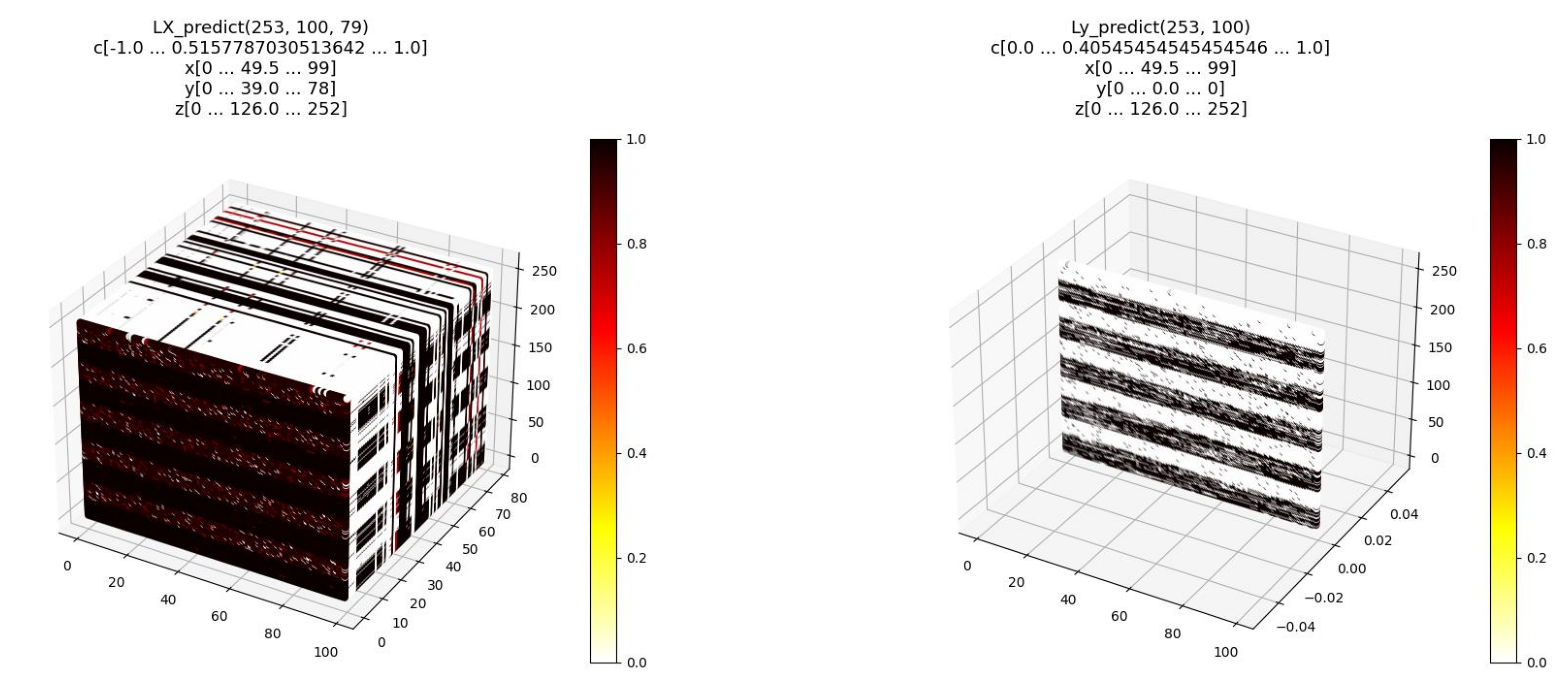

In [14]:
#@title overview featured vs normalized data IMG

show_4d_imgs(['LX_predict','Ly_predict'])

# 4.INTRODUCTION

# 5.LSTM Anomaly State management

## 5.1.Model layers



In [15]:
# threshold(num) là ngưỡng quyết định kết quả dữ đoán là anomaly hay benign, ví dụ: 0.5 ở đây là
# nếu kết quả dự đoán > 0.5 thì xem là anomaly, còn lại là benign, kết quả dự đoán của 1 flow
def threshold(num):
    return 1 if num > 0.5 else 0

def infer_by_checkpoint(checkpoint, name='model6'):
    model = keras.models.load_model(f"/usr/local/opnsense/scripts/ml/aicheckpoints/{checkpoint}/{name}")
    Ly_predict_predicted=model.predict(LX_predict)
    predicted = np.vectorize(threshold)(Ly_predict_predicted)
    
    actual = predicted.ravel()
    expected = Ly_predict.ravel()
    anomaly_detected = anomaly_incorrect = benign_detected = benign_incorrect = 0
    for i in range(0, len(actual)):
        anomaly_detected += actual[i] == expected[i] == 1
        anomaly_incorrect += (actual[i] == 0) & (expected[i] == 1)
        benign_detected += actual[i] == expected[i] == 0
        benign_incorrect += (actual[i] == 1) & (expected[i] == 0)
    
    df = DataFrame.from_dict({
        'checkpoint': [checkpoint],
        'anomaly_detected': [anomaly_detected],
        'anomaly_incorrect': [anomaly_incorrect],
        'benign_detected': [benign_detected],
        'benign_incorrect': [benign_incorrect],
        'detected': [anomaly_detected + benign_detected],
        'incorrect': [anomaly_incorrect + benign_incorrect],
        'detected_rate': [(anomaly_detected + benign_detected) / len(actual)],
        'incorrect_rate': [(anomaly_incorrect + benign_incorrect) / len(actual)],
    })    
    print(df.to_string())

    [IMG['Ly_predict_predicted']] = ray.get([
        show_scattered_4d.remote(Ly_predict_predicted, "Ly_predict_predicted"),
    ])
    show_4d_imgs(['LX_predict','Ly_predict','Ly_predict_predicted'])
    
    return df

___

# 6.LSTM Anomaly model (Primary)

## 6.3.Infer



2023-03-17 16:55:00.489687: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 13348 MB memory:  -> device: 0, name: NVIDIA A16, pci bus id: 0000:3f:00.0, compute capability: 8.6
2023-03-17 16:55:00.490462: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 13348 MB memory:  -> device: 1, name: NVIDIA A16, pci bus id: 0000:40:00.0, compute capability: 8.6
2023-03-17 16:55:00.491210: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:2 with 13348 MB memory:  -> device: 2, name: NVIDIA A16, pci bus id: 0000:41:00.0, compute capability: 8.6
2023-03-17 16:55:00.491936: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1525] Created device /job:localhost/replica:0/task:0/device:GPU:3 with 13348 MB memory:  -> device: 3, name: NVIDIA A16, pci bus id: 0000:42:00.0, compute capability: 8.6


  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W1107             10211                 47            14996                46     25207         93       0.996324        0.003676


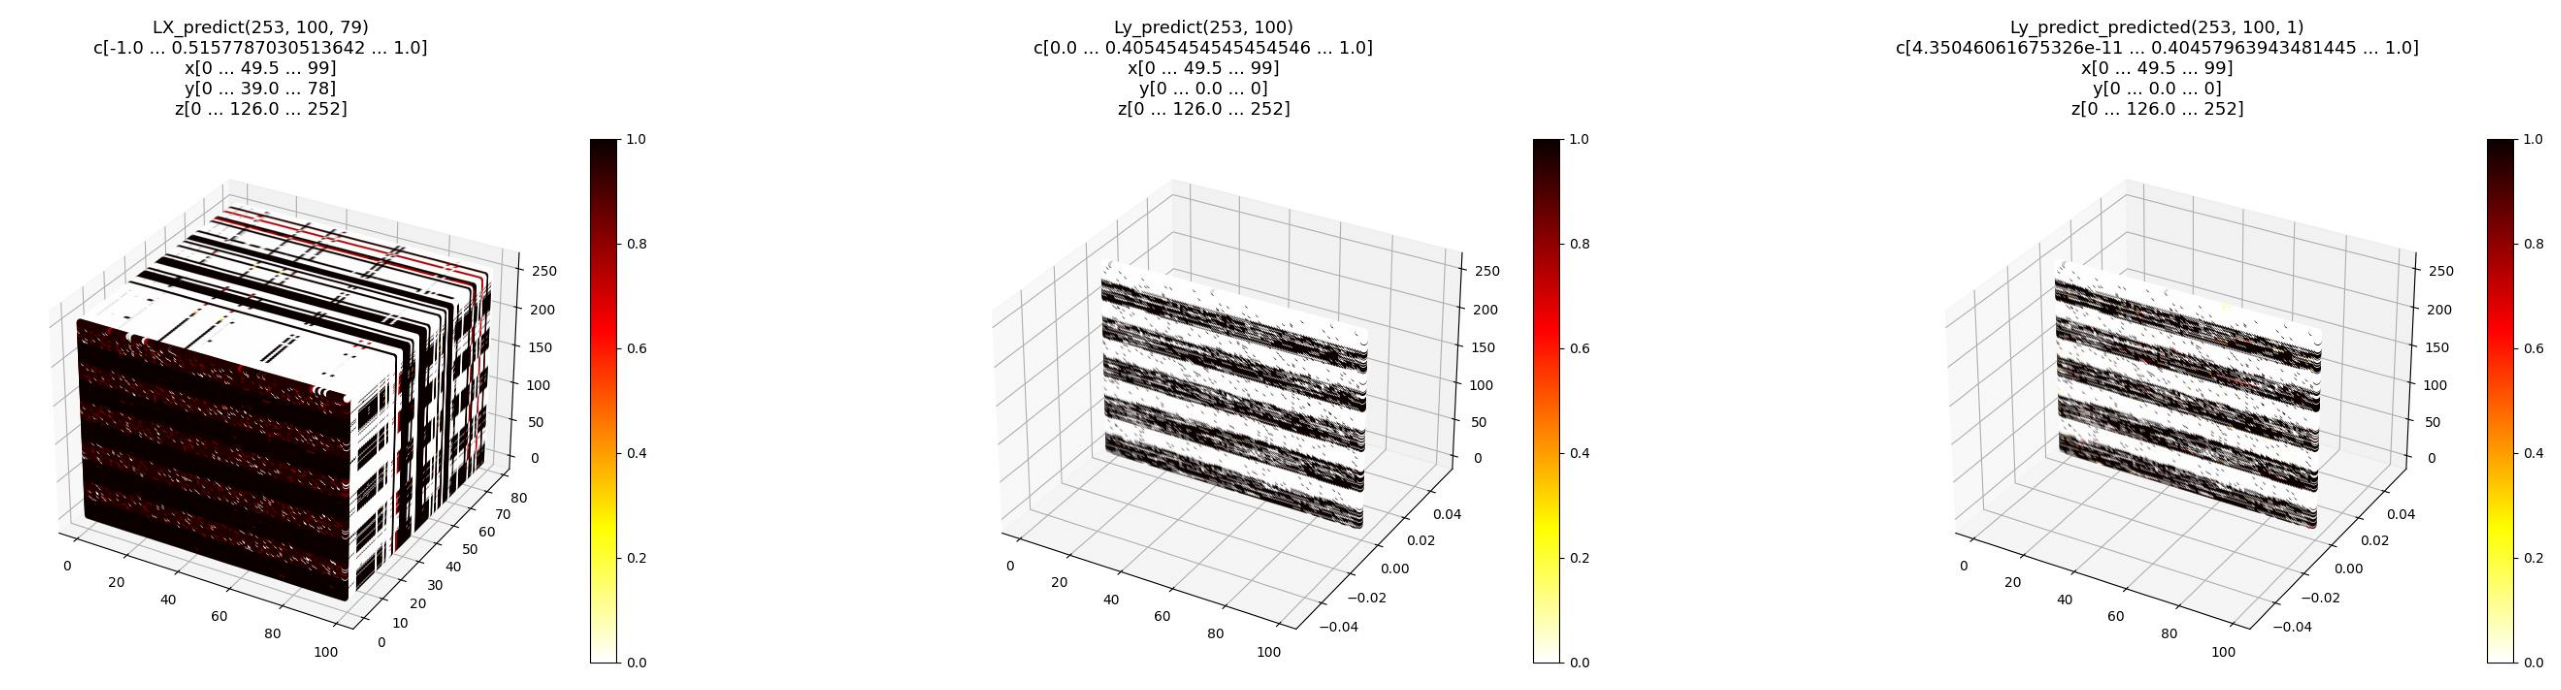

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W1106             10243                 15            14996                46     25239         61       0.997589        0.002411


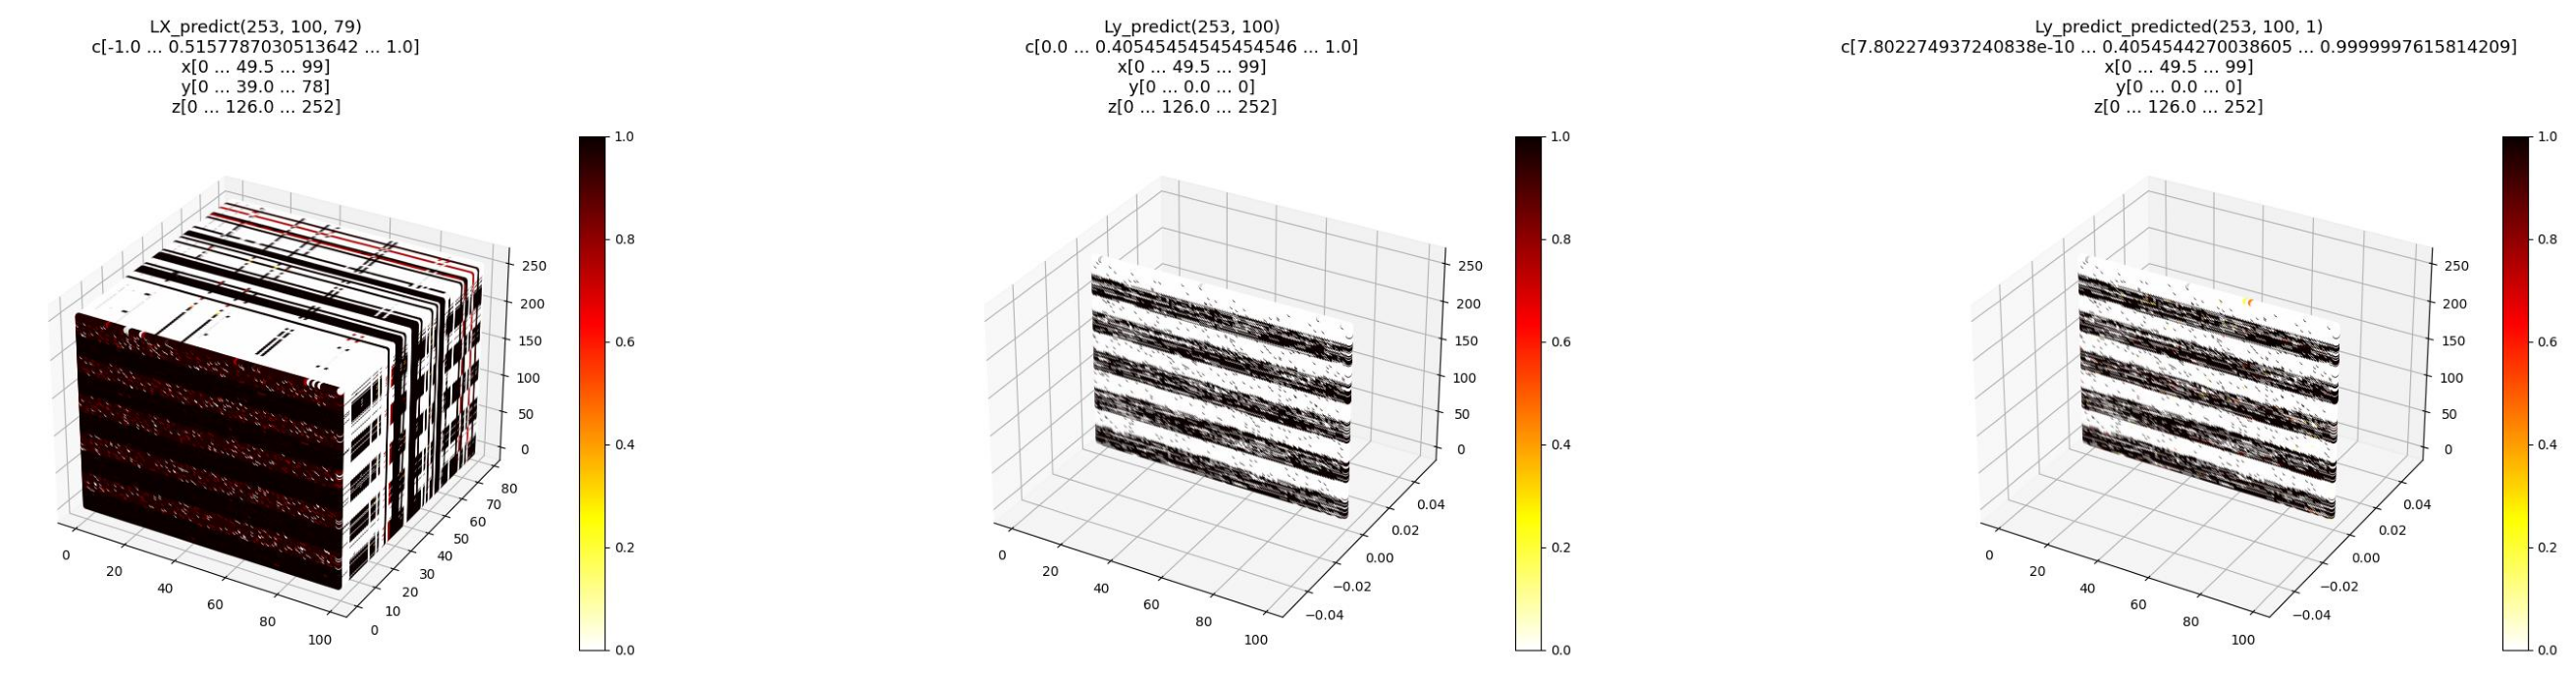

  checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  benign_incorrect  detected  incorrect  detected_rate  incorrect_rate
0  2023W0904              9384                874            14305               737     23689       1611       0.936324        0.063676


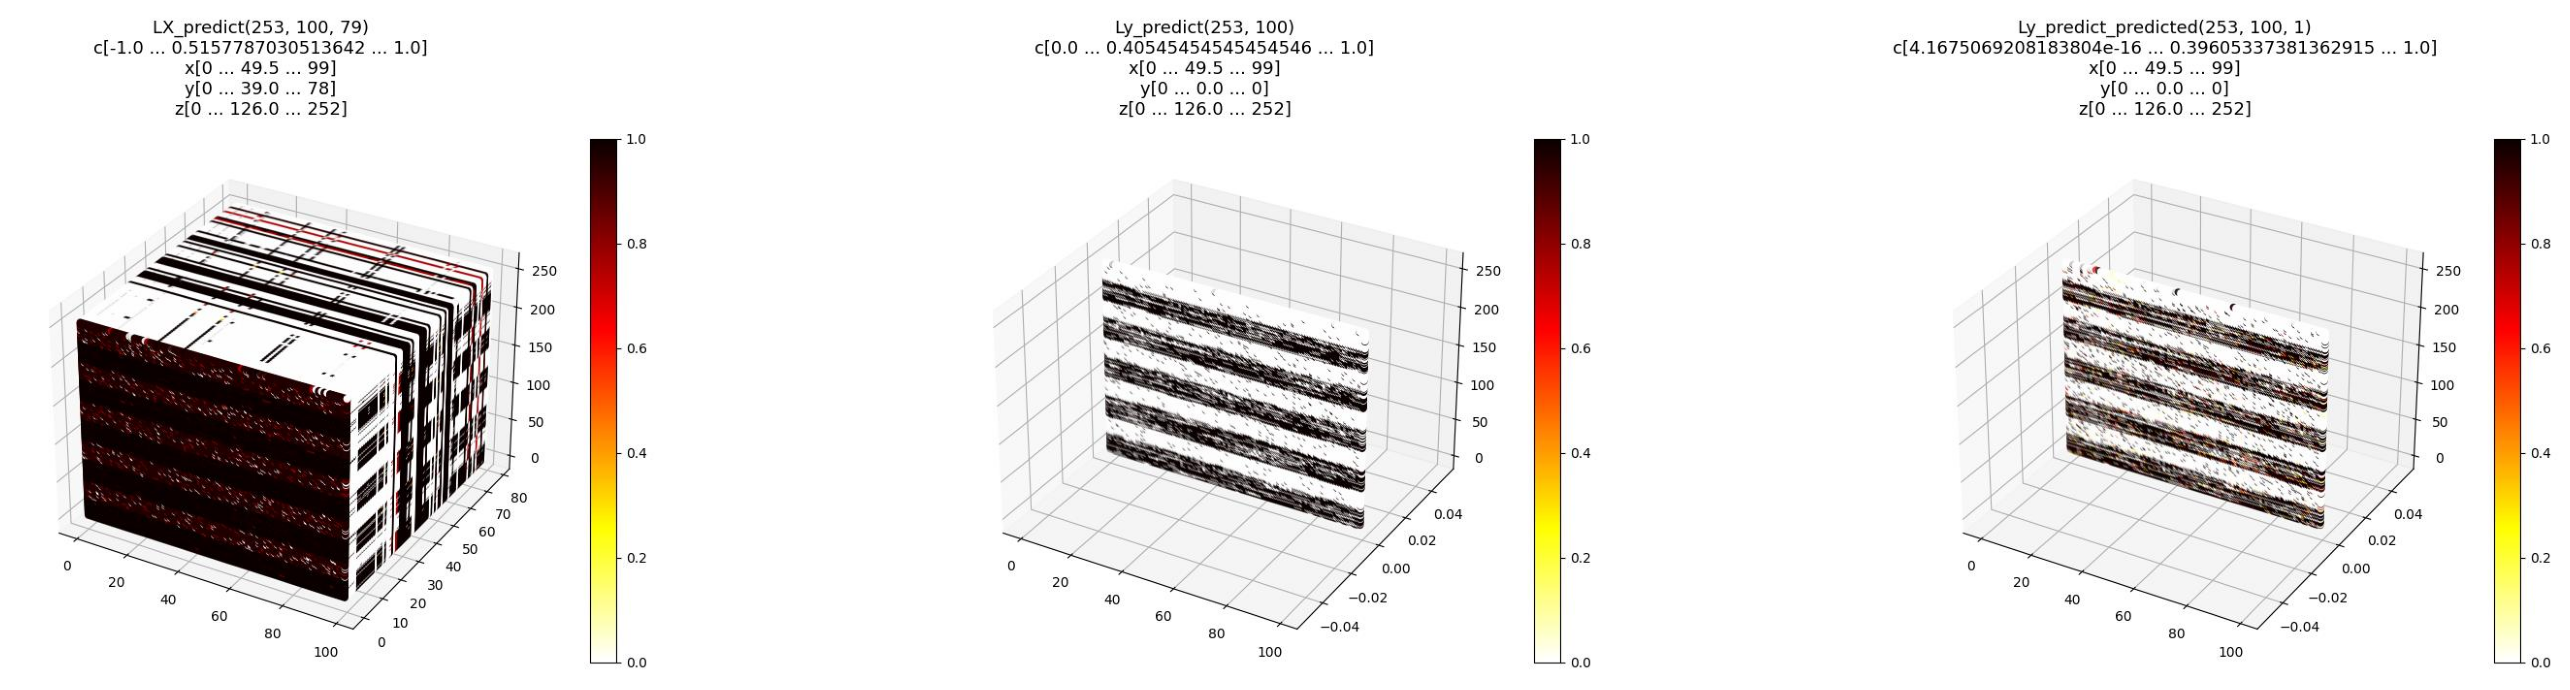

checkpoint  anomaly_detected  anomaly_incorrect  benign_detected  \
0  2023W1107             10211                 47            14996   
1  2023W1106             10243                 15            14996   
2  2023W0904              9384                874            14305   

   benign_incorrect  detected  incorrect  detected_rate  incorrect_rate  
0                46     25207         93       0.996324        0.003676  
1                46     25239         61       0.997589        0.002411  
2               737     23689       1611       0.936324        0.063676

In [16]:
df = DataFrame()
for c in checkpoints:
    dfc = infer_by_checkpoint(c)
    df = pd.concat([df, dfc], axis=0, ignore_index=True)
df